In [60]:
import os
import os.path as op
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.datasets import fetch_fsaverage
from mne.minimum_norm import make_inverse_operator


def create_fsaverage_forward(epochs, mindist=5.0, n_jobs=1):
    """
    A forward model is an estimation of the potential or field distribution for a known source
    and for a known model of the head. Returns EEG forward operator with a downloaded template
    MRI (fsaverage).

	Parameters
	----------
	epochs : mne.epochs.Epochs
		MNE epochs object containing portions of raw EEG data built around specified timestamp(s)

	mindist: float
		Specifies the 'mindist' parameter in the mne.make_forward_solution() function

    n_jobs: int
		Specifies the 'n_jobs' parameter in the mne.make_forward_solution() function

	Returns
	-------
	fwd: mne.forward.forward.Forward
    	Forward operator built from the user_input epochs and the fsaverage brain.
    """

    # Download fsaverage files
    fs_dir = fetch_fsaverage(verbose=True)
    subjects_dir = op.dirname(fs_dir)

    # Used to download/load example MRI brain model
    # The files live in:
    subject = 'fsaverage'
    trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
    src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
    bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

    fwd = mne.make_forward_solution(epochs.info,
                                    trans=trans,
                                    src=src,
                                    bem=bem,
                                    eeg=True,
                                    mindist=mindist,
                                    n_jobs=n_jobs)

    return fwd


def create_inverse_solution(
        epochs,
        forward,
        epoch_num=0,
        covariance_method=[
            'empirical',
            'shrunk'],
        loose=0.2,
        depth=0.8,
        snr=3.0,
        inverse_epochs_method="dSPM",
        pick_ori='normal'):
    """
    Calculates the inverse solution, which is an Estimation of the unknown sources
    corresponding to the measured EEG or MEG.

	Parameters
	----------
	epochs : mne.epochs.Epochs or mne.evoked.EvokedArray
		MNE epochs or evoked object containing portions of raw EEG data built around specified
		timestamp(s). The inverse solution will be built based on the data in the specified epoch.

    forward: mne.forward.forward.Forward
        Specifies the 'forward' parameter in the mne.minimum_norm.make_inverse_operator() function.

	epoch_num: int or str
		If input is an 'int' then this specifies which epoch in the 'epochs' number to build an
		inverse solution from. If input is "all" then an inverse solution will be built from all
		epochs.

	covariance_method: list
		Specifies the 'method' parameter in the mne.compute_covariance() function.

    loose: float
        Specifies the 'loose' parameter in the mne.minimum_norm.make_inverse_operator() function

    depth: depth
        Specifies the 'depth' parameter in the mne.minimum_norm.make_inverse_operator() function

    snr: float
        Used to calculate 'lambda2' in the equation 'lambda2 = 1.0 / snr ** 2'

    inverse_epochs_method: str
        Specifies the 'method' parameter in mne.minimum_norm.apply_inverse_epochs() (if using epochs)
        or mne.minimum_norm.apply_inverse() (if using evoked data).

    pick_ori: str
        Specifies the 'pick_ori' parameter in mne.minimum_norm.apply_inverse_epochs() (if using epochs)
        or mne.minimum_norm.apply_inverse() (if using evoked data).

	Returns
	-------
	stc: mne.source_estimate.SourceEstimate
		Forward operator built from the user_input epochs and the fsaverage brain.
    """
    noise_cov = mne.compute_covariance(epochs, method=covariance_method)

    inverse_operator = make_inverse_operator(epochs.info, forward, noise_cov,
                                             loose=loose, depth=depth)

    lambda2 = 1.0 / snr ** 2

    if isinstance(epoch_num, int):
        epochs = epochs[epoch_num]

    # If epoch_num is any string other than "all" return false

    if isinstance(epochs, mne.epochs.Epochs):
        from mne.minimum_norm import apply_inverse_epochs
        stc = apply_inverse_epochs(epochs,
                                   inverse_operator=inverse_operator,
                                   lambda2=lambda2,
                                   method=inverse_epochs_method,
                                   pick_ori=pick_ori)
        stc = stc[0]

    elif isinstance(epochs, mne.evoked.EvokedArray):
        from mne.minimum_norm import apply_inverse
        stc = apply_inverse(epochs,
                            inverse_operator=inverse_operator,
                            lambda2=lambda2,
                            method=inverse_epochs_method,
                            pick_ori=pick_ori)

    return stc


def plot_topomap_3d_brain(
        epochs,
        stc='auto',
        display_time=0,
        backend = 'auto',
        views=[
            'lateral',
            'dorsal',
            'coronal',
            'frontal'],
        view_layout='horizontal',
        height_per_view=400,
        hemi='both',
        colormap='mne',
        colorbar_limit_type= 'pos_lims_value',
        colorbar_lims=[
                    0,
                    1.5,
                    3],
        colorbar=True,
        transparent=False,
        alpha=1.0,
        cortex='classic',
        background='black',
        foreground='white',
        spacing='oct6',
        smoothing_steps=10,
        figure = None):
    """
    Creates a still image of the epochs or stc data mapped to the brain using the mne.SourceEstimate.plot
    function.

	Parameters
	----------
	epochs : mne.epochs.Epochs or mne.evoked.EvokedArray
		MNE epochs or evoked object containing portions of raw EEG data built around specified
		timestamp(s) The inverse solution will be built based on the data in the specified epoch.

    stc: mne.source_estimate.SourceEstimate or str
		'inverse_solution' to generate the plot from. If set to "auto" then an stc will be
		automatically generated however, this will significantly increase running time.

	display_time: float or None
		Specifies the 'initial_time' parameter in the mne.SourceEstimate.plot() function to show
		a plot at a specific time.

	views: str or list
		Specifies the 'view' parameter in the mne.SourceEstimate.plot() function. Can be any of
		['lateral', 'medial', 'rostral', 'caudal', 'dorsal', 'ventral', 'frontal', 'parietal',
		'axial', 'sagittal', 'coronal']

	view_layout: str
		Specifies the 'view_layout' parameter in the mne.SourceEstimate.plot() function. Should be
		'vertical' or 'horizontal'. Using 'horizontal' with hemi set to 'split' might cause issues.

	height_per_view: int
		Specifies how many pixels tall each "view" of the brian will be. Height is automatically
		calculated based on the number of figures to ensure the dimensions always make all figures
		visible.

	hemi: str
		Specifies the 'initial_time' parameter in the mne.SourceEstimate.plot() function. Can be
		one of ‘lh’, ‘rh’, ‘both’, or ‘split’.

	colormap: str or np.ndarray of float, shape(n_colors, 3 | 4)
		Specifies the 'colormap' parameter in the mne.SourceEstimate.plot() function. Can use a
		matplotlib colormap by name or take a custom look up table as input.

	colorbar_limit_type: str
		Can be one of "auto", "lims_value", "pos_lims_value", "lims_percent", or "pos_lims_percent".
		If set to "auto" then colorbar limits will be automatically calculated. If set to any of the
		other options a combination of "lims"/"pos_lims" and "value"/"percent" will be used to specify
		the colorbar type in the 'colorbar_lims' parameter.

	colorbar_lims: list, 3 elements
		Only used if colorbar_limit_type is set to anything other than "auto". Specifies the lower, middle,
		and upper bounds for colormap will be specified. If a "pos_lims" option was used then positive values
		will be mirrored directly across zero during colormap construction to obtain negative control points.

	colorbar: bool
		Specifies  the 'initial_time' parameter in the mne.SourceEstimate.plot() function. Determines
		whether to include a colorbar on the plot not.

	transparent: bool or None
		Specifies the 'transparent' parameter in the mne.SourceEstimate.plot() function

	alpha: str or list
		Specifies the 'alpha' parameter in the mne.SourceEstimate.plot() function

	cortex: str or tuple
		Specifies the 'cortex' parameter in the mne.SourceEstimate.plot() function

	background: matplotlib color
		Specifies the 'background' parameter in the mne.SourceEstimate.plot() function

	foreground: matplotlib color
		Specifies the 'foreground' parameter in the mne.SourceEstimate.plot() function

	spacing: str
		Specifies the 'spacing' parameter in the mne.SourceEstimate.plot() function

	smoothing_steps: int
		Specifies the 'smoothing_steps' parameter in the mne.SourceEstimate.plot() function

	Returns
	-------
	brain: mne.viz._brain._brain.Brain
    	mne.viz figure of brain with input epoch or stc data mapped to it.
    """

    # if hemi == "split" and view_layout == 'horizontal':
    #     # Return warning that the horizontal with split isn't reccomended
    
    if backend == 'matplotlib':
        print("Warning, when backend is set to matplotlib hemi must be set to 'lh' or 'rh' and only a single view may be provided.") #throw error

    # Calculate stc if one is not provided
    if stc == 'auto':
        forward = create_fsaverage_forward(epochs)
        stc = create_inverse_solution(epochs, forward)
    
    # Calculate font size for colorbar/time label
    colorbar_font_size = round(height_per_view / 25)
    time_label_size = round(height_per_view / 33)

    # add 4/3 of the height in width for each visual
    if view_layout == "horizontal":
        auto_plot_size = [
            round(len(views) * (height_per_view * 4 / 3)), height_per_view]
    elif view_layout == "vertical":
        auto_plot_size = [
            round(
                height_per_view *
                4 /
                3),
            height_per_view *
            len(views)]

    if colorbar_limit_type == 'auto':
        clim_values = 'auto'
    else:
        if colorbar_limit_type == 'lims_value':
            clim_type = 'value'
            lims = 'lims'
        elif colorbar_limit_type == 'pos_lims_value':
            clim_type = 'value'
            lims = 'pos_lims'
        elif colorbar_limit_type == 'lims_percent':
            clim_type = 'percent'
            lims = 'lims'
        elif colorbar_limit_type == 'pos_lims_percent':
            clim_type = 'percent'
            lims = 'pos_lims'
        if lims == 'pos_lims':
            clim_values = dict(kind=clim_type, pos_lims=[colorbar_lims[0],
                                                         colorbar_lims[1],
                                                         colorbar_lims[2]]
                               )
        elif lims == 'lims':
            clim_values = dict(kind=clim_type, lims=[colorbar_lims[0],
                                                     colorbar_lims[1],
                                                     colorbar_lims[2]]
                               )
    
    if type(views) == str:
        views = [views]
            
    def remove_colorbar(image):
        height = image.shape[1]
        cut_height = round(height * 0.25)

        blank_image = np.zeros((cut_height, height,3), np.uint8)
        blank_image[:,0:height] = (0,0,0) 

        x1, x2, y1, y2 = 0, height, 0, (height-cut_height)
        cropped = image[y1:y2, x1:x2]
        combined = np.vstack((cropped,blank_image))

        return combined
    
    def make_plot(
         epoch = epochs,
         stc = stc,
         views=views,
         hemi=hemi,
         colormap=colormap,
         size=auto_plot_size,
         subject=None,
         initial_time=display_time,
         clim=clim_values,
         time_viewer=False,  # Use to open up interactive version
         show_traces=False,
         colorbar=colorbar,
         transparent=transparent,
         alpha=alpha, 
         figure = figure,
         cortex=cortex, 
         background=background, 
         foreground=foreground, 
         spacing=spacing,
         backend = backend,
         view_layout=view_layout,
         smoothing_steps=smoothing_steps,
         time_label_size=time_label_size,
         label_font_size=colorbar_font_size,
         ):
            brain = stc.plot(
                    views=views,
                    surface='inflated',
                    hemi=hemi,
                    colormap=colormap,
                    size=size,
                    subject=None,
                    initial_time=initial_time,
                    clim=clim_values,
                    time_viewer=False, 
                    show_traces=False,
                    colorbar=colorbar,
                    transparent=transparent,
                    alpha=alpha, 
                    figure = figure,
                    cortex=cortex,
                    background=background,  
                    foreground=foreground, 
                    spacing=spacing,
                    backend = backend,
                    view_layout=view_layout,  
                    smoothing_steps=smoothing_steps,
                    add_data_kwargs=dict(time_label_size=time_label_size,
                                      colorbar_kwargs=dict(label_font_size=colorbar_font_size)),
                );
            
            return(brain)
            
            
    if backend != 'matplotlib':
        print("making non matplotlib plot")
        return (make_plot())
    
    elif (hemi == 'lh' and len(views) == 1) or (hemi == 'rh' and len(views) == 1):
        print("making single plot of matplot")
        return (make_plot(views = views[0]))
    
    else:
        view_images = []
            
        for v in range(len(views)):

            brain_images = list()
            
            if hemi == 'both' or hemi == 'split':
                brain_hemi = ['lh', 'rh']
                final_axis = 0 # Will stack images of both hemis vertically
            else:
                brain_hemi = [hemi]
                final_axis = 1 # Will stack each view horizontally

            # run twice for each side of the brain if using both or split
            for i in range(len(brain_hemi)):

                fig, ax = plt.subplots(figsize=(3, 3))

                make_plot(figure = fig, hemi = brain_hemi[i], views = str(views[v]), size = [100,100])

                # Convert figures to images so they can be combined
                ax.margins(0)
                fig.canvas.draw()
                plot_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                plot_image = plot_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                # Get rid of colorbar if not the top left
                if i == 1 or v >= 1:
                    plot_image = remove_colorbar(plot_image)

                brain_images.append(plot_image)
            
            if hemi == 'both' or hemi == 'split':
                view_image = np.concatenate((brain_images[0], brain_images[1]), axis=1)
            else:
                view_image = brain_images[0]
            
            view_images.append(view_image)

    if len(view_images) > 1:
        for i in range(1, len(view_images)):
            view_images[0] = np.concatenate((view_images[0], view_images[i]), axis=final_axis)

    return (view_images[0])
            


def save_animated_topomap_3d_brain(
        brain,
        filename,
        time_dilation=20,
        interpolation='linear',
        framerate=12,
        time_viewer=True):
    """
    Saves an animated mne.viz._brain._brain.Brain object as a gif using the mne.viz.Brain.save_movie()
    function. Saves animation of the entire figure.

	Parameters
	----------
    brain : brain: mne.viz._brain._brain.Brain
		mne.viz figure of brain which will be saved as a gif

    filename: str
		'filename' parameter in mne.viz.Brain.save_movie() function. "Path at which to save the movie.
		The extension determines the format (e.g., '*.mov', '*.gif', …; see the imageio documentation
		for available formats)".

	time_dilation: float
		'time_dilation' parameter in mne.viz.Brain.save_movie() function. "Factor by which to stretch time
		(default 4). For example, an epoch from -100 to 600 ms lasts 700 ms. With time_dilation=4 this
		would result in a 2.8 s long movie."

	interpolation: str or None
		'interpolation' parameter in mne.viz.Brain.save_movie() function. "Interpolation method
		(scipy.interpolate.interp1d parameter). Must be one of ‘linear’, ‘nearest’, ‘zero’, ‘slinear’,
		‘quadratic’, or ‘cubic’."

    time_viewer: bool
		'time_dilation' parameter in mne.viz.Brain.save_movie() function. "If True, include time viewer
		traces".

	Returns
	-------
    """

    brain.save_movie(filename,
                     time_dilation=time_dilation,
                     tmin=brain.data['time'][0],
                     tmax=brain.data['time'][-1],
                     framerate=framerate,
                     interpolation=interpolation,
                     time_viewer=time_viewer)

    
    
def animate_matplot_brain(
                    epochs,
                    stc='auto',
                    display_time=0,
                    backend = 'auto',
                    views=[
                        'lateral',
                        'dorsal',
                        'coronal',
                        'frontal'],
                    view_layout='horizontal',
                    height_per_view=400,
                    hemi='both',
                    colormap='mne',
                    colorbar_limit_type= 'pos_lims_value',
                    colorbar_lims=[
                                0,
                                1.5,
                                3],
                    colorbar=True,
                    transparent=False,
                    alpha=1.0,
                    cortex='classic',
                    background='black',
                    foreground='white',
                    spacing='oct6',
                    smoothing_steps=10,
                    steps=3,
                    frame_rate=12
                        ):
    
    # CURRENTLY UNFINISHED AND IN NEED OF EXTENSIVE BUG TESTING
    # MAIN PROBLEMS ARE THAT IT'S SLOW FOR MULTI AND SINGLE DOESN'T WORK PROPERLY YET

    import matplotlib.animation as animation
    
    if type(views) == str:
        views = [views]

    frames_to_show = round(user_epoch.times.shape[0]/steps)
    times_to_show = np.linspace(user_epoch.tmin, user_epoch.tmax, frames_to_show)

    #FOR TESTING ONLY DELETE LATER
    times_to_show = times_to_show[0:3] #FOR TESTING ONLY DELETE LATER

    ms_between_frames = 1000 / frame_rate
    

    if (hemi == 'lh' and len(views) == 1) or (hemi == 'rh' and len(views) == 1):
        #fig = plt.figure()
        def animate(frame_number):
            fig.clear()
            # NEEDS TO BE UPDATED WITH ALL THE ARGUMENTS
            fig = plot_topomap_3d_brain(user_epoch,
                                             stc = stc,
                                             backend = 'matplotlib',
                                             hemi = hemi,
                                             views = views,
                                             colorbar_limit_type = 'pos_lims_value',
                                             colorbar_lims=[0, 1, 2],
                                             height_per_view = 200,
                                             figure = fig,
                                             display_time = frame_number
                                             )
            return [fig]

    else:
        fig = plt.figure()
        ax = plt.gca()
        
        def animate(frame):

            # remove previous image
            ax.clear()

            # get new image from list
            art = plot_topomap_3d_brain(user_epoch,
                                         stc = stc,
                                         backend = 'matplotlib',
                                         hemi = hemi,
                                         views = views,
                                         colorbar_limit_type = 'pos_lims_value',
                                         colorbar_lims=[0, 1, 2],
                                         height_per_view = 200,
                                         #figure = fig,
                                         display_time = frame
                                         )
            # display new image
            ax.imshow(art)


    ani = animation.FuncAnimation(
        fig,
        animate,
        frames=times_to_show,
        interval=ms_between_frames,  # Time between frames in ms
        blit=False
    )

    return ani

In [2]:
# def animate_topomap_3d_brain(epochs, file_name, stc = 'auto', views = ['lateral', 'dorsal','coronal', 'frontal'],
# 	framerate = 12, interpolation = 'linear', time_dilation = 20, view_layout = 'horizontal',
# 	pixel_height_per_view = 200, hemi = 'both', colormap = 'mne', colorbar_limit_type = 'auto',
# 	colorbar_lims = [0, 8, 10], colorbar = True, transparent = False, alpha = 1.0, cortex = 'classic',
# 	background = 'black', foreground = 'white', spacing = 'oct6', smoothing_steps = 10):

# 	# Calculate stc if one is not provided
# 	if stc == 'auto':
# 		forward = create_fsaverage_forward(epochs)
# 		stc = create_inverse_solution(epochs, forward)

# 	brain = plot_topomap_3d_brain(epochs, stc = stc, display_time = 0, views = views,
# 	view_layout = view_layout, pixel_height_per_view = pixel_height_per_view, hemi = hemi, colormap = colormap,
# 	colorbar_limit_type = colorbar_limit_type, colorbar_lims = colorbar_lims, colorbar = colorbar,
# 	transparent = transparent, alpha = alpha, cortex = cortex, background = background, foreground = 'white',
# 	spacing = spacing, smoothing_steps = smoothing_steps)

# 	brain.save_movie(file_name,
#                  time_dilation = time_dilation,
#                  tmin = stc.tmin,
#                  tmax = stc.times[-1],
#                  framerate = framerate,
#                  interpolation=interpolation,
#                  time_viewer=True)

## Prep environment

In [3]:
# Specify electrode layout
electrode_layout = 'standard_1020' # toggle to switch to 'standard_1005' if needed, default to 'standard_1020'.

# Calculate starting/ending frames
start_hour = 0
start_minute = 2
start_second = 34
start_ms = 0

end_hour = 0
end_minute = 2
end_second = 34
end_ms = 200

In [4]:
raw = mne.io.read_raw_eeglab('../data/1122/fixica.set')
raw = raw.set_eeg_reference(projection=True)
montage = mne.channels.make_standard_montage(electrode_layout)

Reading /Users/mpin/Documents/MDS/capstone/simpl_eeg_capstone/data/1122/fixica.fdt


<ipython-input-4-b0254cc0d099>:1: RuntimeWarning: Data file name in EEG.data (1122 fix ica.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw = mne.io.read_raw_eeglab('../data/1122/fixica.set')


Adding average EEG reference projection.
1 projection items deactivated


In [5]:
sampling_freq_hz = raw.info.get('sfreq') 

start_frame = round((sampling_freq_hz/1000) * start_ms) \
    + (start_second * sampling_freq_hz) \
    + (start_minute * (sampling_freq_hz * 60)) \
    + (start_hour * (sampling_freq_hz * 3600))

end_frame = round((sampling_freq_hz/1000) * end_ms) \
    + (end_second * sampling_freq_hz) \
    + (end_minute * (sampling_freq_hz * 60)) \
    + (end_hour * (sampling_freq_hz * 3600))

duration = (end_frame - start_frame) / sampling_freq_hz # duration of specified window in seconds

print("start frame is", start_frame, "at", str(start_hour) + ":" + str(start_minute) + ":" + str(start_second) + "." + str(start_ms))
print("end frame is", end_frame, "at", str(end_hour) + ":" + str(end_minute) + ":" + str(end_second) + "." + str(end_ms))
print("duration is", duration, "seconds")

start frame is 315392.0 at 0:2:34.0
end frame is 315802.0 at 0:2:34.200
duration is 0.2001953125 seconds


In [6]:
# Set up events and use it to generate mock epoch and evoked data

user_event_frame = round((start_frame + end_frame)/2) # Pick frame in the middle of the two specified frames to build epoch around
user_event = ([[int(user_event_frame), 0, 1]]) # Format event to make mock epoch
user_event = np.array(user_event)

min_time = 0 - duration/2 # time to start from before epoch, should line up with user specified start time
max_time = 0 + duration/2 # time to stop from after epoch time, should line up with user specified end time

In [7]:
event_dict = {'user_specified_time': 1} # Create single mock event, needed to make epoch 

user_epoch = mne.Epochs(raw,
                        user_event,
                        tmin = min_time,
                        tmax = max_time,
                        event_id = event_dict,
                        preload=True)

user_evoked = user_epoch['user_specified_time'].average()

Not setting metadata
Not setting metadata
1 matching events found
Setting baseline interval to [-0.10009765625, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 1 events and 411 original time points ...
0 bad epochs dropped


## Test functions

### Build forward and reverse
--------

In [8]:
%%time
fwd = create_fsaverage_forward(user_epoch)

0 files missing from root.txt in /Users/mpin/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage
Source space          : /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /Users/mpin/opt/miniconda3/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000 

In [9]:
%%time
stc = create_inverse_solution(user_epoch, fwd)

Computing rank from data with rank=None
    Using tolerance 9.7e-13 (2.2e-16 eps * 19 dim * 2.3e+02  max singular value)
    Estimated rank (eeg): 18
    EEG: rank 18 computed from 19 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 19 -> 18
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using SHRUNK
Done.
Using cross-validation to select the best estimator.
Number of samples used : 411
log-likelihood on unseen data (descending order):
   shrunk: -13.255
   empirical: -109.926
selecting best estimator: shrunk
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 19 channels.
    19 out of 19 channels remain after picking
Se

### Test all individual plotting options
--------

In [10]:
%%time
test_fig = plot_topomap_3d_brain(user_epoch, stc = stc)

making non matplotlib plot
Using pyvista 3d backend.

CPU times: user 11.5 s, sys: 1.25 s, total: 12.7 s
Wall time: 12.8 s


Warning, when backend is set to matplotlib hemi must be set to 'lh' or 'rh' and only a single view may be provided.
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


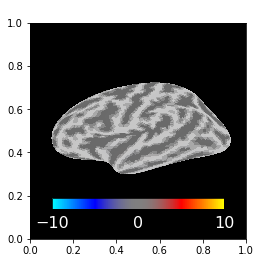

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


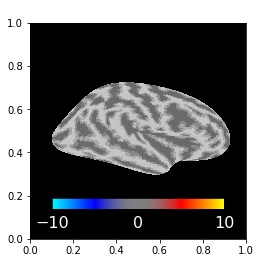

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


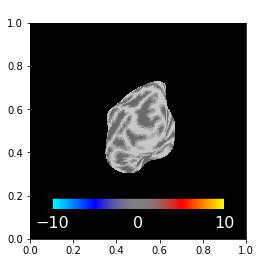

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


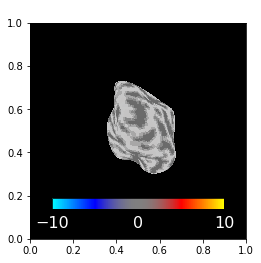

<class 'numpy.ndarray'>
(432, 432, 3)
CPU times: user 41.2 s, sys: 2.3 s, total: 43.5 s
Wall time: 11.5 s


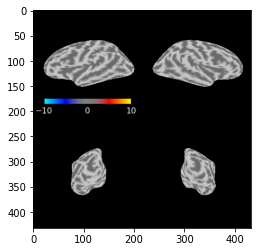

In [19]:
%%time
test_multi_matplotlib = plot_topomap_3d_brain(user_epoch,
                                         stc = stc,
                                         backend = 'matplotlib',
                                         hemi = 'both',
                                         views = ['lat', 'cau'],
                                         colorbar_limit_type = 'pos_lims_value',
                                         colorbar_lims=[0, 5, 10]
                                         )

print(type(test_multi_matplotlib))
print(test_multi_matplotlib.shape)
plt.imshow(test_multi_matplotlib)

Warning, when backend is set to matplotlib hemi must be set to 'lh' or 'rh' and only a single view may be provided.
making single plot of matplot
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


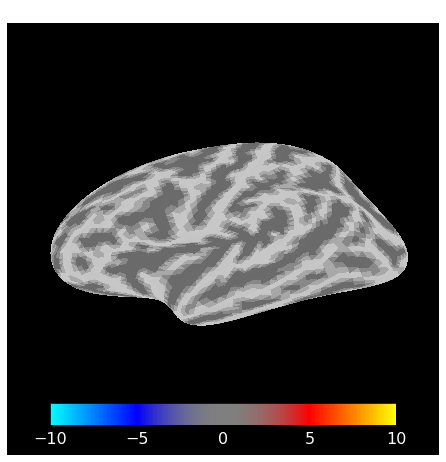

<class 'matplotlib.figure.Figure'>


In [12]:
test_single_fig_matplot = plot_topomap_3d_brain(user_epoch,
                                         stc = stc,
                                         backend = 'matplotlib',
                                         hemi = 'lh',
                                         views = 'lat',
                                         colorbar_limit_type = 'pos_lims_value',
                                         colorbar_lims=[0, 5, 10]
                                         )

print(type(test_single_fig_matplot))

Warning, when backend is set to matplotlib hemi must be set to 'lh' or 'rh' and only a single view may be provided.
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


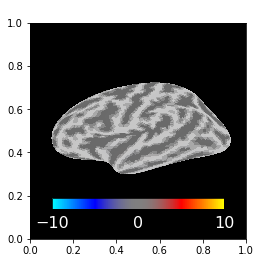

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


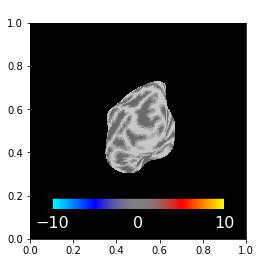

<class 'numpy.ndarray'>
(216, 432, 3)


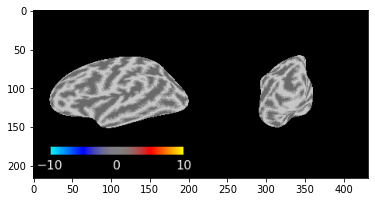

In [61]:
test_single_hemi_multivew_matplot = plot_topomap_3d_brain(user_epoch,
                                         stc = stc,
                                         backend = 'matplotlib',
                                         hemi = 'lh',
                                         views = ['lat', 'cau'],
                                         colorbar_limit_type = 'pos_lims_value',
                                         colorbar_lims=[0, 5, 10]
                                         )

print(type(test_single_hemi_multivew_matplot))
print(test_single_hemi_multivew_matplot.shape)
plt.imshow(test_single_hemi_multivew_matplot)

In [15]:
%%time
save_animated_topomap_3d_brain(test_fig, filename = "test_brain2.gif")

CPU times: user 7.15 s, sys: 490 ms, total: 7.64 s
Wall time: 8.49 s


-------

In [91]:
def animate_matplot_brain(
                    epochs,
                    stc='auto',
                    display_time=0,
                    backend = 'auto',
                    views=[
                        'lateral',
                        'dorsal',
                        'coronal',
                        'frontal'],
                    view_layout='horizontal',
                    height_per_view=400,
                    hemi='both',
                    colormap='mne',
                    colorbar_limit_type= 'pos_lims_value',
                    colorbar_lims=[
                                0,
                                1.5,
                                3],
                    colorbar=True,
                    transparent=False,
                    alpha=1.0,
                    cortex='classic',
                    background='black',
                    foreground='white',
                    spacing='oct6',
                    smoothing_steps=10,
                    steps=3,
                    frame_rate=12
                        ):
    
    # CURRENTLY UNFINISHED AND IN NEED OF EXTENSIVE BUG TESTING
    # MAIN PROBLEMS ARE THAT IT'S SLOW FOR MULTI AND SINGLE DOESN'T WORK PROPERLY YET

    import matplotlib.animation as animation
    
    if type(views) == str:
        views = [views]

    frames_to_show = round(user_epoch.times.shape[0]/steps)
    times_to_show = np.linspace(user_epoch.tmin, user_epoch.tmax, frames_to_show)

    #FOR TESTING ONLY DELETE LATER
    times_to_show = times_to_show[0:3] #FOR TESTING ONLY DELETE LATER

    ms_between_frames = 1000 / frame_rate
    

    if (hemi == 'lh' and len(views) == 1) or (hemi == 'rh' and len(views) == 1):
        #fig = plt.figure()
        def animate(frame_number):
            fig.clear()
            # NEEDS TO BE UPDATED WITH ALL THE ARGUMENTS
            fig = plot_topomap_3d_brain(user_epoch,
                                             stc = stc,
                                             backend = 'matplotlib',
                                             hemi = hemi,
                                             views = views,
                                             colorbar_limit_type = 'pos_lims_value',
                                             colorbar_lims=[0, 1, 2],
                                             height_per_view = 200,
                                             figure = fig,
                                             display_time = frame_number
                                             )
            return [fig]

    else:
        fig = plt.figure()
        ax = plt.gca()
        
        def animate(frame):

            # remove previous image
            ax.clear()

            # get new image from list
            art = plot_topomap_3d_brain(user_epoch,
                                         stc = stc,
                                         backend = 'matplotlib',
                                         hemi = hemi,
                                         views = views,
                                         colorbar_limit_type = 'pos_lims_value',
                                         colorbar_lims=[0, 1, 2],
                                         height_per_view = 200,
                                         #figure = fig,
                                         display_time = frame
                                         )
            # display new image
            ax.imshow(art)


    ani = animation.FuncAnimation(
        fig,
        animate,
        frames=times_to_show,
        interval=ms_between_frames,  # Time between frames in ms
        blit=False
    )

    return ani

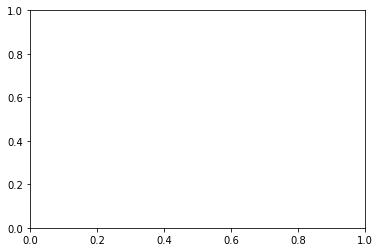

In [93]:
test_matplot_animate_multi = animate_matplot_brain(
    user_epoch,
    stc = stc,
    backend = 'matplotlib',
    hemi = 'lh',
    views = ['lat', 'cau'],
    colorbar_limit_type = 'pos_lims_value',
    colorbar_lims=[0, 5, 10]
)

Warning, when backend is set to matplotlib hemi must be set to 'lh' or 'rh' and only a single view may be provided.
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


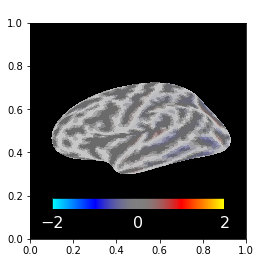

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


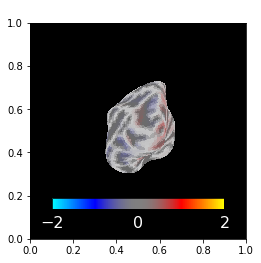

Warning, when backend is set to matplotlib hemi must be set to 'lh' or 'rh' and only a single view may be provided.
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


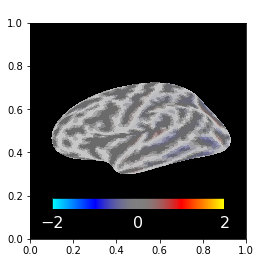

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


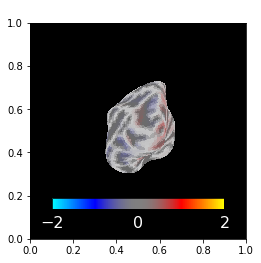

Warning, when backend is set to matplotlib hemi must be set to 'lh' or 'rh' and only a single view may be provided.
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


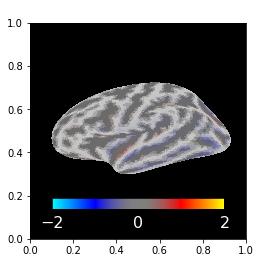

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


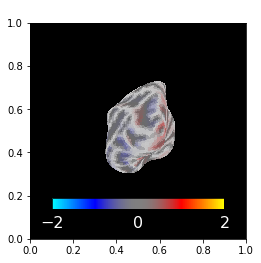

Warning, when backend is set to matplotlib hemi must be set to 'lh' or 'rh' and only a single view may be provided.
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


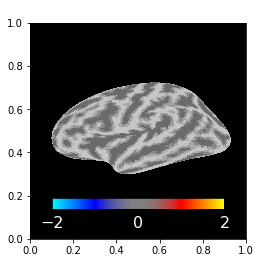

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


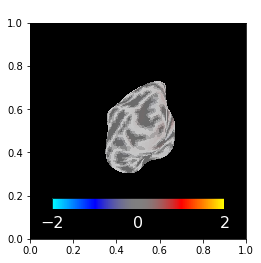

In [94]:
from IPython.display import HTML
HTML(test_matplot_animate_multi.to_jshtml())

In [92]:
test_matplot_animate_single = animate_matplot_brain(
    user_epoch,
    stc = stc,
    backend = 'matplotlib',
    hemi = 'lh',
    views = 'lat',
    colorbar_limit_type = 'pos_lims_value',
    colorbar_lims=[0, 5, 10]
)

UnboundLocalError: local variable 'fig' referenced before assignment

In [90]:
%%time
HTML(test_matplot_animate_single.to_jshtml())

UnboundLocalError: local variable 'fig' referenced before assignment

In [ ]:
fig, ax = plt.figure(figsize=(3, 3))

brain = stc.plot(backend = 'matplotlib',
                         initial_time = 0,
                         hemi = 'rh',
                         size = [100, 100],
                         background = 'black',
                         figure = fig
                        );

# To remove the huge white borders
ax.margins(0)
fig.canvas.draw()


plot_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
plot_image = plot_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [ ]:
#fig = plt.figure(figsize=(3, 3))
fig, ax = plt.subplots(figsize=(3, 3))

brain = stc.plot(backend = 'matplotlib',
                         initial_time = 0,
                         hemi = 'lh',
                         size = [100, 100],
                         background = 'black',
                         figure = fig
                        );

# To remove the huge white borders
#ax.margins(0)
fig.canvas.draw()

plot_image2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
plot_image2 = plot_image2.reshape(fig.canvas.get_width_height()[::-1] + (3,))

plot_image2 = remove_colorbar(plot_image2)

In [ ]:
type(image_from_plot)

In [ ]:
def remove_colorbar(image):
    height = image.shape[1]
    cut_height = round(height * 0.25)

    blank_image = np.zeros((cut_height, height,3), np.uint8)
    blank_image[:,0:height] = (0,0,0) 

    x1, x2, y1, y2 = 0, height, 0, (height-cut_height)
    cropped = image[y1:y2, x1:x2]
    combined = np.vstack((cropped,blank_image))

    return combined

In [ ]:
fig = plt.figure(figsize=(3, 3))

brain = stc.plot(backend = 'matplotlib',
                         initial_time = 0,
                         hemi = 'lh',
                         size = [100, 100],
                         background = 'black',
                         figure = fig,
                         add_data_kwargs=dict(colorbar = False,
                              colorbar_kwargs=dict()),
                        );

# To remove the huge white borders
ax.margins(0)
plt.axis('off')
fig.canvas.draw()

image_from_plot2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
image_from_plot2 = image_from_plot2.reshape(fig.canvas.get_width_height()[::-1] + (3,))
image_from_plot2 = remove_colorbar(image_from_plot2)

In [ ]:
comb_image = np.concatenate((plot_image, plot_image2), axis=1)
#plot_image = np.concatenate((plot_image, plot_image), axis=0)

plt.axis('off')
plt.imshow(comb_image)

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')

stc.plot(backend = 'matplotlib',
                         initial_time = 0,
                         hemi = 'lh',
                         size = [100, 100],
                         background = 'black',
                         figure = fig
                        );


#axs[1].plot(x, -y)

Using control points [0.50214107 0.5804117  1.14456482]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


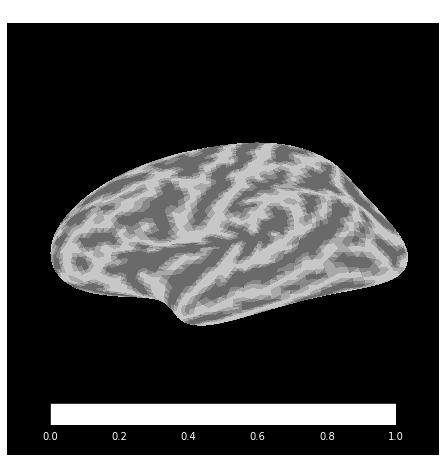

In [55]:
#fig, ax = plt.subplots(figsize=(3, 3))

stc.plot(backend = 'matplotlib',
                         initial_time = 0,
                         hemi = 'lh',
                         size = [100, 100],
                         background = 'black',
                         colorbar = None
                         #figure = fig
                        );

